In [1]:
import numpy as np, numpy, pandas as pd, matplotlib.pyplot as plt, regex as re
import seaborn as sns
import hetio.readwrite, json
from hetmech.matrix import *
from hetmech.dwpc import *
from plotnine import *
%matplotlib inline
plt.style.use(['default'])
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":10})

/home/zietz/anaconda3/envs/hetmech/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/zietz/anaconda3/envs/hetmech/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
times = pd.read_csv('data/all_times.tsv', sep='\t')

## All metapaths

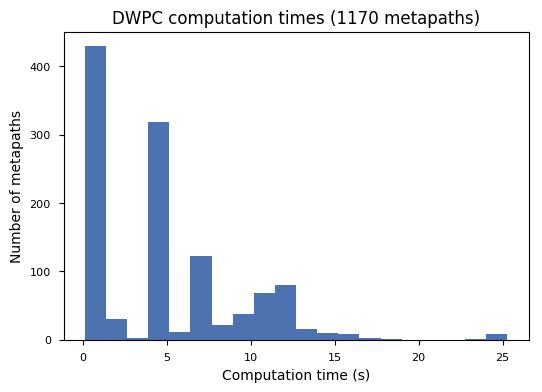

In [3]:
plt.figure(figsize=(6,4))
plt.title('DWPC computation times (1170 metapaths)')
plt.xlabel('Computation time (s)')
plt.ylabel('Number of metapaths')

plt.hist(list(times['Time']), bins=20, color=sns.color_palette('deep')[0]);

## G_X_G metapaths

In [4]:
G_G_times = pd.DataFrame([[path, times['Time'][i]] for i, path in enumerate(list(times['Metapath'])) 
             if re.findall('[G][a-z<>{1,2}][A-Z{1,2}][a-z<>{1,2}][G]', path)], columns=('Metapath', 'Time'))

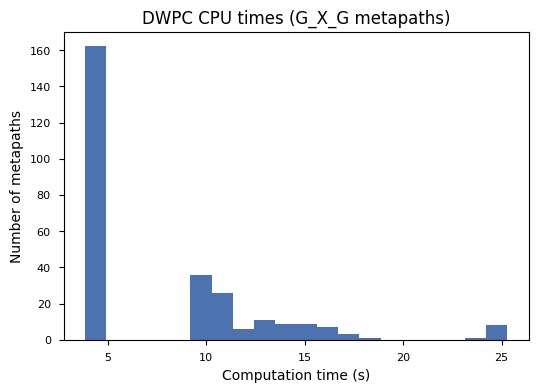

In [5]:
plt.figure(figsize=(6,4))
plt.title('DWPC CPU times (G_X_G metapaths)')
plt.xlabel('Computation time (s)')
plt.ylabel('Number of metapaths')

plt.hist(G_G_times['Time'], bins=20, color=sns.color_palette('deep')[0]);

## By number of Genes in metapath

In [6]:
G_G_times[G_G_times['Time'] > 40]

,Metapath,Time


In [7]:
times[times['Time'] > 40]

,Metapath,Time


This shows that the longest nine metapaths were all of the G_X_G form

In [8]:
n_gene_meta = [metapath.count('G') for metapath in times['Metapath']]
times['num_gene'] = n_gene_meta

In [9]:
data = [times[times['num_gene'] == i]['Time'] for i in range(3)]

In [10]:
times.head()

,Metapath,Time,num_gene
0,CpDpCpD,0.202120,0
1,CpDpCtD,0.196876,0
2,CpDtCpD,0.201098,0
3,CtDpCpD,0.195657,0
4,CiPCiCpD,0.214499,0


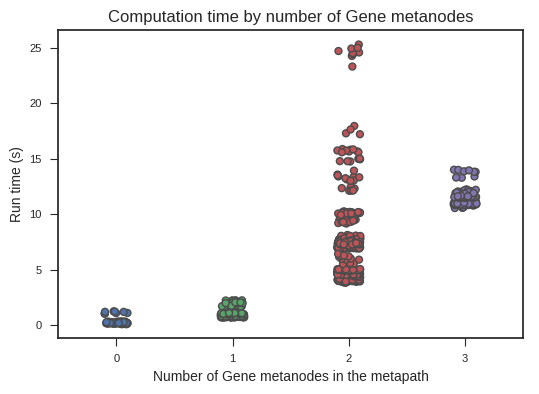

In [11]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(6,4))
    plt.title('Computation time by number of Gene metanodes')
    ax = sns.stripplot(x='num_gene', y='Time', data=times, jitter=True, 
                       palette=sns.color_palette("deep", desat=0.9), linewidth=1);
    ax.set(xlabel='Number of Gene metanodes in the metapath', ylabel='Run time (s)')
    plt.show()

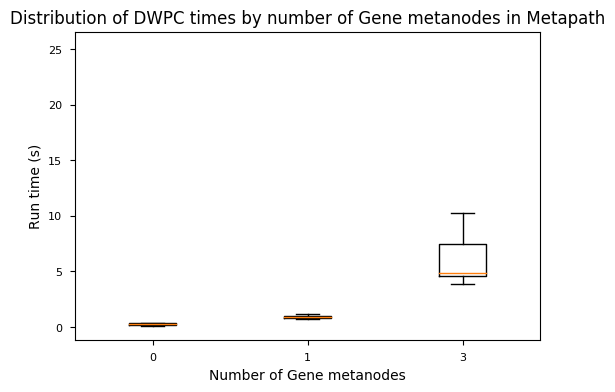

In [12]:
plt.figure(figsize=(6,4))
plt.title('Distribution of DWPC times by number of Gene metanodes in Metapath')
plt.xlabel('Number of Gene metanodes')
plt.ylabel('Run time (s)')
plt.boxplot(data, labels=(0, 1, 3));

### Split G_X_G into G_X_G and G_A_G

In [13]:
GAG = []
for metapath in G_G_times['Metapath']:
    if re.findall('[G][a-z<>{1,2}][A][a-z<>{1,2}][G]', metapath):
        GAG.append(True)
    else:
        GAG.append(False)
GAG_times = G_G_times[GAG]

not_GAG = [not i for i in GAG]
not_GAG_times = G_G_times[not_GAG]

In [14]:
data = [GAG_times['Time'], not_GAG_times['Time']]

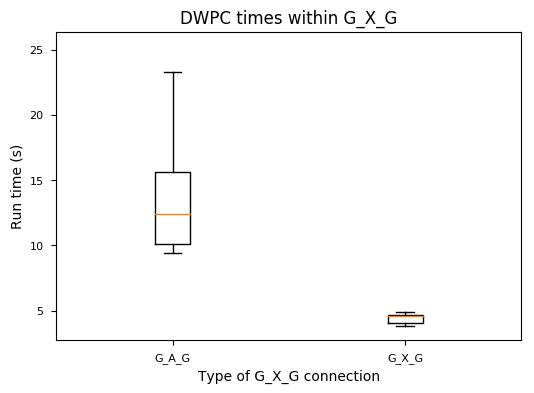

In [15]:
plt.figure(figsize=(6,4))
plt.title('DWPC times within G_X_G')
plt.xlabel('Type of G_X_G connection')
plt.ylabel('Run time (s)')

plt.boxplot(data, labels=('G_A_G', 'G_X_G'));

### Split into GeAeG and G_A_G and G_X_G

In [16]:
GeAeG = []
for metapath in GAG_times['Metapath']:
    if re.findall('GeAeG', metapath):
        GeAeG.append(True)
    else:
        GeAeG.append(False)
GeAeG_times = GAG_times[GeAeG]

not_GeAeG = [not i for i in GeAeG]
not_GeAeG_times = GAG_times[not_GeAeG]

In [17]:
data = [not_GAG_times['Time'], not_GeAeG_times['Time'], GeAeG_times['Time']]

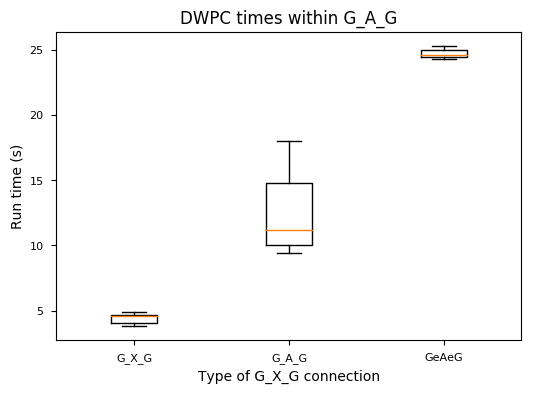

In [18]:
plt.figure(figsize=(6,4))
plt.title('DWPC times within G_A_G')
plt.xlabel('Type of G_X_G connection')
plt.ylabel('Run time (s)')
plt.boxplot(data, labels=('G_X_G', 'G_A_G', 'GeAeG'));

## By number of metaedges in the metapath

In [19]:
n_edges = [len(re.findall('[A-Z]{1,2}', metapath)) for metapath in times['Metapath']]

In [20]:
times['num_edge'] = n_edges

In [21]:
data = [times[times['num_edge'] == i]['Time'] for i in (3,4,5)]

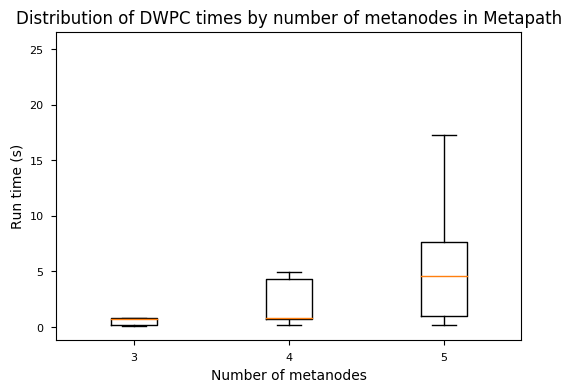

In [22]:
plt.figure(figsize=(6,4))
plt.title('Distribution of DWPC times by number of metanodes in Metapath')
plt.xlabel('Number of metanodes')
plt.ylabel('Run time (s)')
plt.boxplot(data, labels=(3,4,5));

## By category

In [23]:
times

,Metapath,Time,num_gene,num_edge
0,CpDpCpD,0.202120,0,4
1,CpDpCtD,0.196876,0,4
2,CpDtCpD,0.201098,0,4
3,CtDpCpD,0.195657,0,4
4,CiPCiCpD,0.214499,0,4
5,CpDtCtD,0.195565,0,4
6,CtDpCtD,0.202588,0,4
7,CtDtCpD,0.197908,0,4
8,CiPCiCtD,0.215660,0,4
9,CbGbCpD,0.814135,1,4


### Load the graph

In [24]:
%%time
url = 'data/hetionet-v1.0.json'
graph = hetio.readwrite.read_graph(url)
metagraph = graph.metagraph

CPU times: user 1min 6s, sys: 2.6 s, total: 1min 9s
Wall time: 1min 14s


### Load metapaths

In [25]:
with open('data/metapaths.json') as data_file:
    metapaths = json.load(data_file)

metapaths.sort(key=lambda x: x['join_complexities'][0])

In [26]:
# Extract the actual metapaths from the list of metapath dictionaries
abbrevs = [metapath['abbreviation'] for metapath in metapaths]

### Categorize the metapaths

In [27]:
types = []
for metapath in abbrevs:
    m_path = metagraph.metapath_from_abbrev(metapath)
    cat = categorize(m_path)
    types.append([metapath, cat])
types = pd.DataFrame(types, columns=("Metapath", "Category"))

In [28]:
types.tail()

,Metapath,Category
1201,CbGeAeGaD,short_repeat
1202,CdGeAeGdD,short_repeat
1203,CdGeAeGuD,short_repeat
1204,CuGeAeGaD,short_repeat
1205,CdGeAeGaD,short_repeat


In [29]:
categories = []
for i in times['Metapath']:
    categories.append(list(types[types['Metapath'] == i]['Category'])[0])
times['category'] = categories

In [30]:
times.head()

,Metapath,Time,num_gene,num_edge,category
0,CpDpCpD,0.202120,0,4,BABA
1,CpDpCtD,0.196876,0,4,BABA
2,CpDtCpD,0.201098,0,4,BABA
3,CtDpCpD,0.195657,0,4,BABA
4,CiPCiCpD,0.214499,0,4,short_repeat


### Plot the number and runtime by category

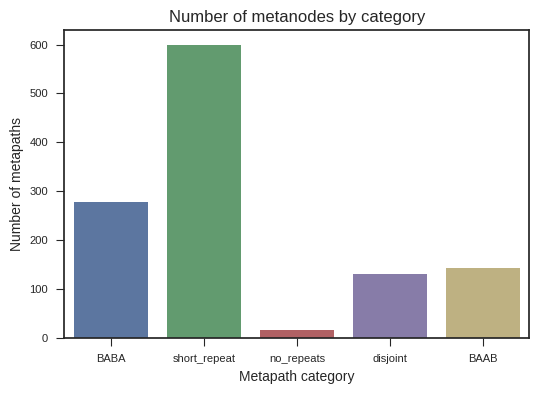

In [31]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(6,4))
    plt.title('Number of metanodes by category')
    ax = sns.countplot(x='category', data=times, palette=sns.color_palette('deep', desat=0.9));
    ax.set(xlabel='Metapath category', ylabel='Number of metapaths')
    plt.show()


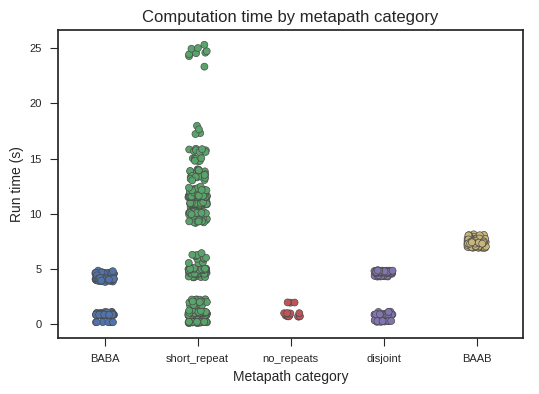

In [32]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(6,4))
    plt.title('Computation time by metapath category')
    ax = sns.stripplot(x='category', y='Time', jitter=True,
                       data=times, linewidth=0.5, palette=sns.set_palette('deep', desat=0.9));
    ax.set(xlabel='Metapath category', ylabel='Run time (s)')
    plt.show()

In [33]:
times = times.sort_values(by='num_edge', ascending=False)

In [34]:
times['Path length'] = times['num_edge']

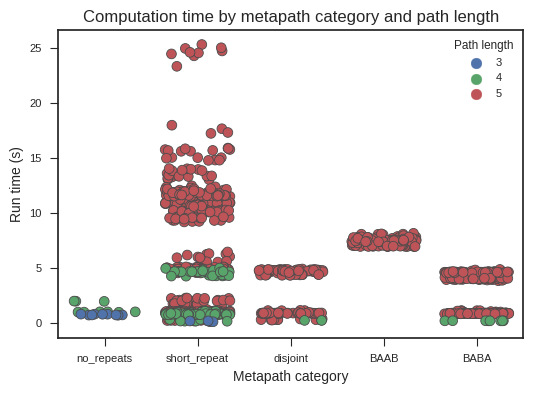

In [35]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(6,4))
    plt.title('Computation time by metapath category and path length')
    ax = sns.stripplot(x='category', y='Time', hue='Path length', hue_order=[3,4,5], 
                       order=['no_repeats', 'short_repeat', 'disjoint', 'BAAB', 'BABA'], split=False, size=7,
                       data=times, jitter=0.35, linewidth=0.6, palette=sns.set_palette('deep', desat=0.9));
    ax.set(xlabel='Metapath category', ylabel='Run time (s)')
    plt.show()

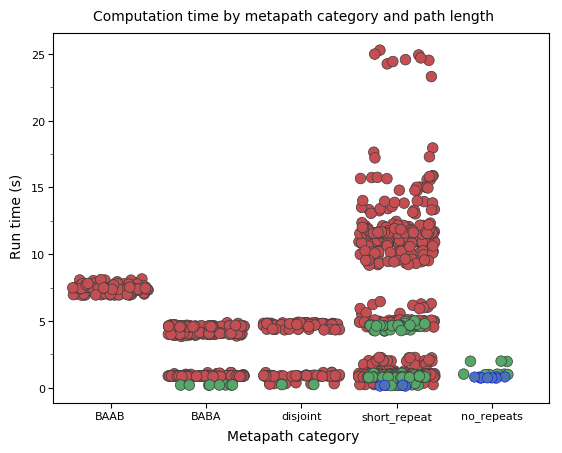

<ggplot: (-9223363256233030498)>

In [36]:
(ggplot(times, aes(x='category', y='Time', color='num_edge'))
 + geom_jitter(data=times[times['num_edge'] == 5], width=0.4, size=4, fill='#C44E52', 
               color='#3f3f3f', alpha=1, stroke=0.3)
 + geom_jitter(data=times[times['num_edge'] == 4], width=0.3, size=4, fill='#55A868', 
               color='#3f3f3f', alpha=1, stroke=0.3)
 + geom_jitter(data=times[times['num_edge'] == 3], width=0.2, size=4, fill='#4C72B0', 
               color='b', alpha=1, stroke=0.2)
 + scale_color_discrete()
 + labs(title="Computation time by metapath category and path length", 
        x="Metapath category", y="Run time (s)", fill="Metapath length", color='Metapath length')
 + scale_fill_identity(name='Metapath length', guide='legend', labels=['m1','m2','m3'])
 + theme_matplotlib()
)